### Florian Muthreich   ---   INF368   ---

# Assignment 1

load necessary packages

In [1]:
import matplotlib.pyplot as plt
import keras
import random
import numpy as np

Using TensorFlow backend.


Next I download the MNIST dataset. It is already split in test and training set and saved to variables. The images are stored separately from the labels in arrays.

In [17]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

The MNIST set has been downloaded and I can show the dimensions of the dataset.
In total there are 70000 images of handwritten numbers. 60000 in the train set and 10000 in the test set. each image is 28 x 28 pixels and has only one channel, which means each cell indicates the intensity of a pixel. The labels are stored separately in their own array, which basically has the shape of a vector.

In [3]:
print("Training set:",x_train.shape, ", labels", y_train.shape)
print("Test set:",x_test.shape, ", labels", y_test.shape)

Training set: (60000, 28, 28) , labels (60000,)
Test set: (10000, 28, 28) , labels (10000,)


Here I plot 6 random images from the MNIST dataset. 3 from the train and 3 from the test set.

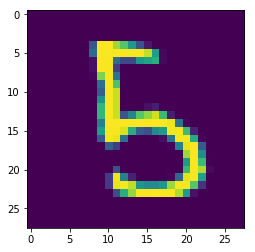

Train-set img: 10400 label : 5


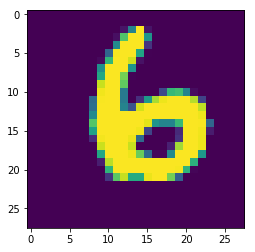

Train-set img: 25405 label : 6


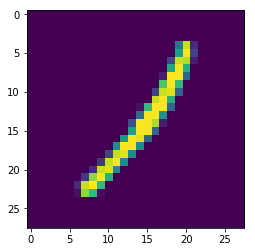

Train-set img: 44369 label : 1


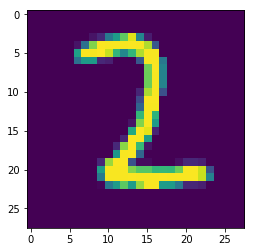

Test-set img: 3655 label : 2


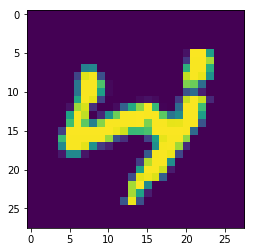

Test-set img: 9615 label : 4


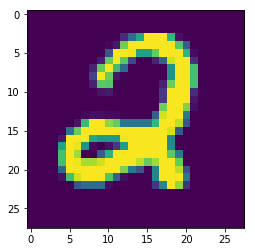

Test-set img: 147 label : 2


In [4]:
for x in range(6):
    if x<3:
        i = random.randint(1,x_train.shape[0])
        img = plt.imshow(x_train[i])
        plt.show()
        print("Train-set img:", i, "label :", y_train[i])
    else:
        i = random.randint(1,x_test.shape[0])
        img = plt.imshow(x_test[i])
        plt.show()
        print("Test-set img:", i, "label :", y_test[i])

I defined a function to transform the training data into 4D vectors. The same function also converts the labels into one hot coded vectors. 

In [18]:
def res_rec(data, labels, channels):
    tmp = data.reshape(data.shape[0], channels, data.shape[1], data.shape[2])
    tmp = tmp.astype("float32")
    tmp = tmp/np.amax(x_train)
    lbl = keras.utils.to_categorical(labels, len(np.unique(labels)))
    return tmp, lbl

x_train, y_train = res_rec(x_train, y_train, 1)
x_test, y_test = res_rec(x_test, y_test, 1)

print("Training set:",x_train.shape, ", labels", y_train.shape)
print("Test set:",x_test.shape, ", labels", y_test.shape)

Training set: (60000, 1, 28, 28) , labels (60000, 10)
Test set: (10000, 1, 28, 28) , labels (10000, 10)


This model has 1 hidden layer with 50 units. and a second layer with 10 softmax units. the number of parameters can be derived from this model. 
We have 784 input features 
number of weights between neurons
784 * 50 39200
50 * 10 500
number of weights for bias
50
10

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

model = Sequential([
    Flatten(input_shape = (1,28, 28)),
    Dense(50), #, input_shape = (784,)
    Activation("sigmoid"),
    Dense(10),
    Activation("softmax")
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                39250     
_________________________________________________________________
activation_5 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer = "sgd",
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

#x_train = x_train.reshape(60000,784)

ind = random.sample(range(x_train.shape[0]), int(1/12 * x_train.shape[0]))
x_valid, y_valid = x_train[ind], y_train[ind]
x_train, y_train = np.delete(x_train, ind, axis = 0), np.delete(y_train, ind, axis = 0)

checkpoints = keras.callbacks.ModelCheckpoint("./checkpoints/model_{epoch:02d}.hdf5", 
                                              monitor='val_loss', 
                                              verbose=0, 
                                              save_best_only=False, save_weights_only=False)


In [20]:
trained = model.fit(x_train, y_train, 
                    epochs = 5, batch_size = 64, 
                    callbacks = [checkpoints], 
                    validation_data = (x_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 1s 26us/step - loss: 0.6049 - acc: 0.8629 - val_loss: 0.5649 - val_acc: 0.8756
Epoch 2/5
55000/55000 [==============================] - 1s 23us/step - loss: 0.5476 - acc: 0.8709 - val_loss: 0.5170 - val_acc: 0.8846
Epoch 3/5
55000/55000 [==============================] - 1s 25us/step - loss: 0.5057 - acc: 0.8773 - val_loss: 0.4816 - val_acc: 0.8874
Epoch 4/5
55000/55000 [==============================] - 1s 23us/step - loss: 0.4737 - acc: 0.8822 - val_loss: 0.4543 - val_acc: 0.8896
Epoch 5/5
55000/55000 [==============================] - 1s 27us/step - loss: 0.4486 - acc: 0.8859 - val_loss: 0.4321 - val_acc: 0.8922


In [22]:
import pandas as pd

tested_eval = model.evaluate(x_test, y_test, batch_size = 128)
tested_pred = model.predict(x_test, batch_size = 128)

actu = np.argmax(y_test, axis = 1, out = None)
pred = np.argmax(tested_pred, axis = 1, out = None)

confusion = pd.crosstab(actu, pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
confusion

10000/10000 [==============================] - 0s 10us/step


Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,954,0,3,1,0,6,6,1,9,0,980
1,0,1084,6,4,0,0,4,2,35,0,1135
2,19,16,860,14,15,0,27,13,64,4,1032
3,6,2,22,882,1,23,4,14,43,13,1010
4,5,9,2,1,871,0,13,1,9,71,982
5,45,7,9,83,7,598,21,10,96,16,892
6,21,3,15,1,11,14,888,0,5,0,958
7,7,27,29,3,12,1,0,892,10,47,1028
8,12,7,13,29,9,10,13,10,859,12,974


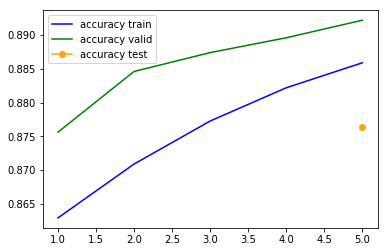

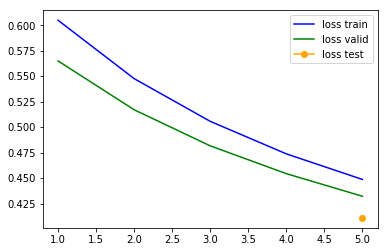

In [23]:
plt.plot(range(1,6), trained.history["acc"], color = "blue")
plt.plot(range(1,6), trained.history["val_acc"], color = "green")
plt.plot(5, tested_eval[1], marker = "o", color = "orange")
plt.legend(["accuracy train", "accuracy valid", "accuracy test"])
plt.show()

plt.plot(range(1,6), trained.history["loss"], color = "blue")
plt.plot(range(1,6), trained.history["val_loss"], color = "green")
plt.plot(5, tested_eval[0], marker = "o", color = "orange")
plt.legend(["loss train", "loss valid", "loss test"])
plt.show()

In [ ]:
tbcallback = keras.callbacks.TensorBoard(log_dir='./logs', 
                            histogram_freq=0, 
                            batch_size=32, 
                            write_graph=True, write_grads=True, write_images=True, 
                            embeddings_freq=0, embeddings_layer_names=None, 
                            embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
callbacks = [tbcallback]

In [ ]:
new_model = keras.models.load_model('./checkpoints/model_01.hdf5')
new_model.summary()
new_model.evaluate(x_train, y_train, batch_size = 128)

In [ ]:
ind = random.sample(range(x_train.shape[0]), int(1/12 * x_train.shape[0]))
x_valid, y_valid = x_train[ind], y_train[ind]
x_train, y_train = np.delete(x_train, ind, axis = 0), np.delete(y_train, ind, axis = 0)

In [ ]:
json_string = model.to_json()
model.save_weights(filepath)
model.load_weights(filepath, by_name=False)

In [ ]:
with open("model_num.json", "w") as json_file:
    json_file.write(json_string)
    
json_file = open('model_num.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)